# Exploratory Data Analysis: Mars Hyperspectral Imaging

**Author:** Riccardo Finotello <riccardo.finotello@cea.fr>

---

## Introduction

In this tutorial, we explore **hyperspectral imaging (HSI)** data from Mars, specifically from the **CRISM** instrument aboard the Mars Reconnaissance Orbiter.
Hyperspectral imaging allows us to capture detailed spectral information for each pixel in an image, enabling the identification of minerals and materials, based on information on the surface.

## 1. Setup and Data Loading

First, we import the necessary libraries and load our hyperspectral image data.

In [1]:
# Import required libraries
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# Import the HSIMars class from our package
from hsimars import HSIMars

# Configure matplotlib for better-looking plots
plt.style.use("grayscale")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 16

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.3.3


### 1.1 Initialize the HSIMars Object

We load one of the CRISM images along with its ground truth annotations. The ground truth labels tell us what materials are present at each pixel location (annotated by experts).

In [2]:
# Path to our hyperspectral image and annotations
# Note: Adjust these paths based on your directory structure
hdr_path = "../data/HC_frt0000580c_07_if164j_ter3.hdr"
annotations_path = "../data/HC_ground_truth.mat"

# Initialize the HSIMars object
# This doesn't load the data yet, but it uses lazy loading for efficiency
hsi = HSIMars(hdr_path=hdr_path, annotations=annotations_path)

print("✅ HSIMars object created successfully!")
print(f"📁 Header file: {hsi.hdr_path.name}")
print(
    f"🏷️  Annotations file: {hsi.annotations.name if hsi.annotations else 'None'}"
)

✅ HSIMars object created successfully!
📁 Header file: HC_frt0000580c_07_if164j_ter3.hdr
🏷️  Annotations file: HC_ground_truth.mat


## 2. Understanding the Data Structure

We then load the hyperspectral image and examine its structure.

In [3]:
# Load the hyperspectral image data
img_data = hsi.get_img()

print("=" * 50)
print("HYPERSPECTRAL IMAGE PROPERTIES")
print("=" * 50)
print(f"📐 Image shape: {img_data.shape}")
print(f"   - Height (rows): {img_data.height} pixels")
print(f"   - Width (columns): {img_data.width} pixels")
print(f"   - Spectral channels: {img_data.channels} bands")
print(f"\n📊 Data type: {img_data.dtype}")
print(
    f"🌈 Wavelength range: {img_data.wavelength.min():.2f} - {img_data.wavelength.max():.2f} nm"
)
print(f"💾 Memory size: {img_data.hsi.nbytes / (1024**2):.2f} MB")
print("=" * 50)

HYPERSPECTRAL IMAGE PROPERTIES
📐 Image shape: (418, 600, 483)
   - Height (rows): 418 pixels
   - Width (columns): 600 pixels
   - Spectral channels: 483 bands

📊 Data type: float32
🌈 Wavelength range: 436.13 - 3896.76 nm
💾 Memory size: 462.10 MB


### 2.1 Interpreting the Data Structure

Break down the structure of the image:

- **Image Dimensions**: the image is organized as a 3D array with shape `(height, width, channels)`
  - **Height & Width**: spatial dimensions (like a regular photo)
  - **Channels**: the spectral dimension (each channel corresponds to a specific wavelength)

- **Data Type**: `float32` (32-bit floating point numbers representing reflectance values)

- **Wavelength Range**: spans from visible (400-700 nm) through near-infrared (700-3000 nm)

In [4]:
# Let's examine the wavelength array more closely
print("SPECTRAL BAND INFORMATION")
print("=" * 50)
print(f"First 10 wavelengths (nm): {img_data.wavelength[:10].round(1)}")
print(f"Last 10 wavelengths (nm): {img_data.wavelength[-10:].round(1)}")
print(
    f"\nMean spacing between bands: {np.diff(img_data.wavelength).mean():.2f} nm"
)
print(f"Min spacing: {np.diff(img_data.wavelength).min():.2f} nm")
print(f"Max spacing: {np.diff(img_data.wavelength).max():.2f} nm")
print("=" * 50)

SPECTRAL BAND INFORMATION
First 10 wavelengths (nm): [436.1 442.6 449.1 455.6 462.2 468.6 475.2 481.7 488.2 494.7]
Last 10 wavelengths (nm): [3836.7 3843.4 3850.  3856.7 3863.4 3870.1 3876.7 3883.4 3890.1 3896.8]

Mean spacing between bands: 7.18 nm
Min spacing: 6.50 nm
Max spacing: 158.63 nm


### 2.2 Spectral Band Categories

Different wavelength regions tell us different things about materials. Thus, it is appropriate to try to categorise our spectral bands:

SPECTRAL REGION BREAKDOWN
📗 VIS  (Visible, < 750 nm):           38 bands
📕 NIR  (Near-Infrared, 750-1400 nm):  94 bands
📘 SWIR (Short-Wave IR, 1400-3000 nm): 218 bands
📙 MWIR (Mid-Wave IR, > 3000 nm):      133 bands

Total: 483 bands


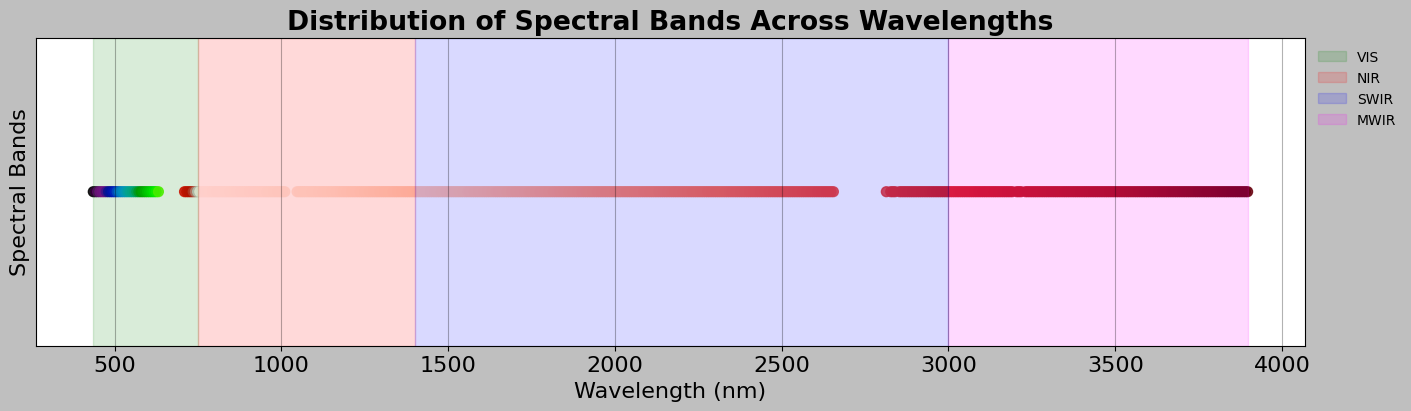

In [5]:
# Categorize wavelengths into standard spectral regions
wl = img_data.wavelength

# Count bands in each spectral region
vis_bands = np.sum(wl < 750)  # Visible
nir_bands = np.sum((wl >= 750) & (wl < 1400))  # Near-Infrared
swir_bands = np.sum((wl >= 1400) & (wl < 3000))  # Short-Wave Infrared
mwir_bands = np.sum(wl >= 3000)  # Mid-Wave Infrared

print("SPECTRAL REGION BREAKDOWN")
print("=" * 50)
print(f"📗 VIS  (Visible, < 750 nm):          {vis_bands:3d} bands")
print(f"📕 NIR  (Near-Infrared, 750-1400 nm): {nir_bands:3d} bands")
print(f"📘 SWIR (Short-Wave IR, 1400-3000 nm): {swir_bands:3d} bands")
print(f"📙 MWIR (Mid-Wave IR, > 3000 nm):      {mwir_bands:3d} bands")
print(f"\nTotal: {vis_bands + nir_bands + swir_bands + mwir_bands} bands")
print("=" * 50)

# Create a visualization of the spectral sampling
fig, ax = plt.subplots(figsize=(14, 4), layout="constrained")
ax.scatter(
    wl[wl < 750],
    np.ones_like(wl[wl < 750]),
    c=wl[wl < 750],
    cmap="nipy_spectral",
    s=50,
    alpha=0.85,
)
ax.scatter(
    wl[(wl >= 750)],
    np.ones_like(wl[(wl >= 750)]),
    c=wl[(wl >= 750)],
    cmap="Reds",
    s=50,
    alpha=0.85,
)
ax.axvspan(wl.min(), 750, alpha=0.15, color="green", label="VIS")
ax.axvspan(750, 1400, alpha=0.15, color="red", label="NIR")
ax.axvspan(1400, 3000, alpha=0.15, color="blue", label="SWIR")
ax.axvspan(3000, wl.max(), alpha=0.15, color="magenta", label="MWIR")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Spectral Bands")
ax.set_title(
    "Distribution of Spectral Bands Across Wavelengths",
    fontweight="bold",
)
ax.set_yticks([])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

## 3. Visual Exploration: False-Color Images

Hyperspectral data has hundreds of channels, but we can only display 3 at a time (RGB) for rendering. We can create some false-color visualisations to see spatial patterns in the data.

### 3.1 What is a False-Color Image?

A **false-color image** displays data using colors that do not match the true colors we would see with our eyes. This is done to:
- Highlight features not visible to the human eye (e.g.: infrared)
- Enhance contrast between different materials
- Visualise data outside the visible spectrum

We select three spectral bands and map them to Red, Green, and Blue channels for display.

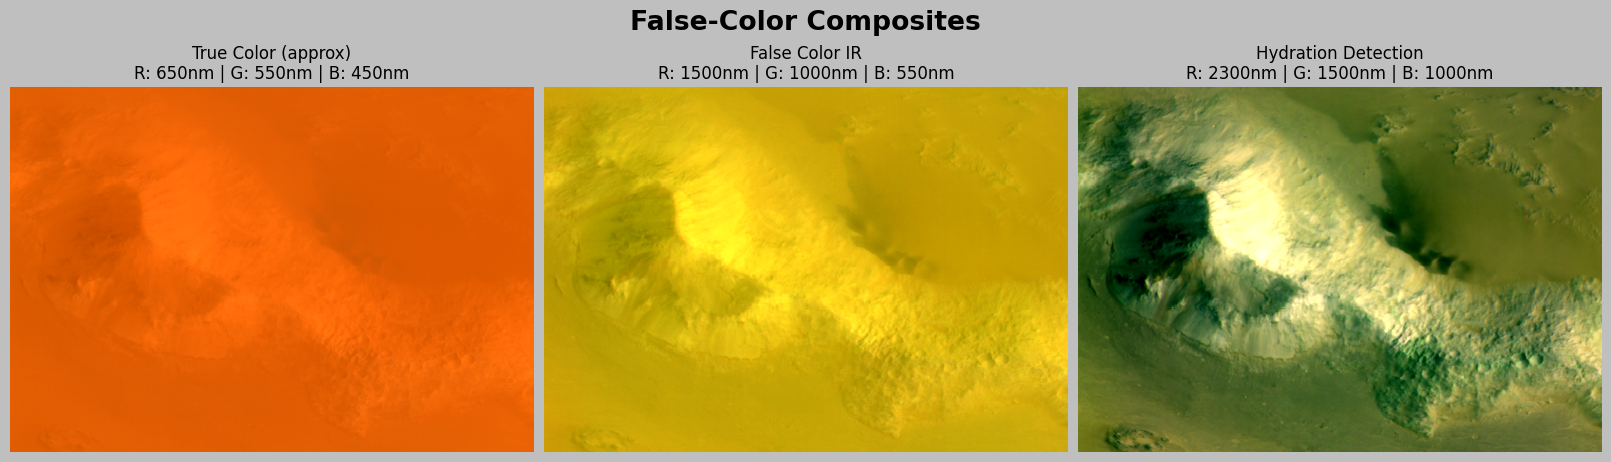

In [6]:
# Find indices for specific wavelengths
def find_band_index(wavelength_nm):
    """Find the band index closest to a given wavelength."""
    return np.argmin(np.abs(img_data.wavelength - wavelength_nm))


# Define some useful band combinations
band_combos = {
    "True Color (approx)": (650, 550, 450),  # R, G, B wavelengths
    "False Color IR": (1500, 1000, 550),  # Emphasizes minerals
    "Hydration Detection": (2300, 1500, 1000),  # Good for hydrated minerals
}

fig, ax = plt.subplots(1, 3, figsize=(16, 5), layout="constrained")

for ax, (name, (r_wl, g_wl, b_wl)) in zip(ax, band_combos.items()):
    # Get band indices
    r_idx = find_band_index(r_wl)
    g_idx = find_band_index(g_wl)
    b_idx = find_band_index(b_wl)

    # Extract the three bands
    r_band = img_data.hsi[:, :, r_idx]
    g_band = img_data.hsi[:, :, g_idx]
    b_band = img_data.hsi[:, :, b_idx]

    # Stack into RGB image and normalize
    rgb = np.dstack([r_band, g_band, b_band])

    # Normalize to 0-1 range for display
    rgb_min = np.percentile(rgb, 2)  # 2nd percentile
    rgb_max = np.percentile(rgb, 98)  # 98th percentile
    rgb_normalized = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

    # Display
    ax.imshow(rgb_normalized)
    ax.set_title(
        f"{name}\nR: {r_wl}nm | G: {g_wl}nm | B: {b_wl}nm", fontsize=12
    )
    ax.axis("off")

plt.suptitle(
    "False-Color Composites",
    fontweight="bold",
    y=1.02,
)
plt.show()

## 4. Spectral Signature Analysis

Now let us look at the **spectral signatures**, since each pixel contains a full spectrum that acts like a fingerprint for material identification.

### 4.1 Single Pixel Spectrum

Consider the spectrum of a single pixel to understand what information it contains.

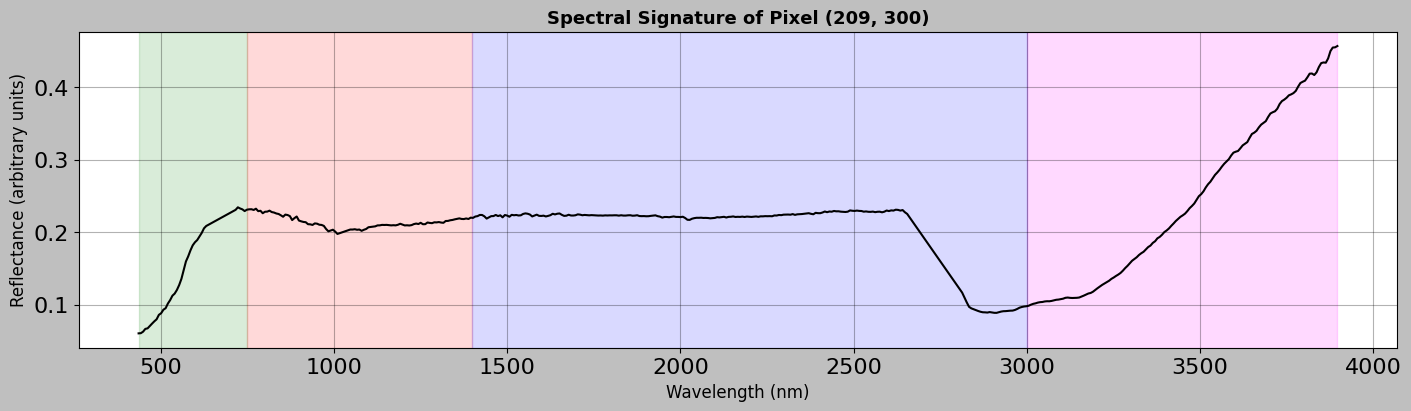

In [7]:
# Select a pixel to analyze (let's choose one near the center)
center_row = img_data.height // 2
center_col = img_data.width // 2

# Extract the spectrum for this pixel
spectrum = img_data.hsi[center_row, center_col, :]

# Create a comprehensive plot
fig, ax = plt.subplots(figsize=(14, 4), layout="constrained")

# Top panel: Full spectrum
ax.plot(
    img_data.wavelength, spectrum, "k-", linewidth=1.5, label="Raw Spectrum"
)
ax.axvspan(wl.min(), 750, alpha=0.15, color="green")
ax.axvspan(750, 1400, alpha=0.15, color="red")
ax.axvspan(1400, 3000, alpha=0.15, color="blue")
ax.axvspan(3000, wl.max(), alpha=0.15, color="magenta")
ax.set_xlabel("Wavelength (nm)", fontsize=12)
ax.set_ylabel("Reflectance (arbitrary units)", fontsize=12)
ax.set_title(
    f"Spectral Signature of Pixel ({center_row}, {center_col})",
    fontsize=13,
    fontweight="bold",
)
ax.grid(True, alpha=0.3)
plt.show()

### 4.2 Comparing Multiple Pixel Spectra

Compare spectra from different locations to see how much they differ.

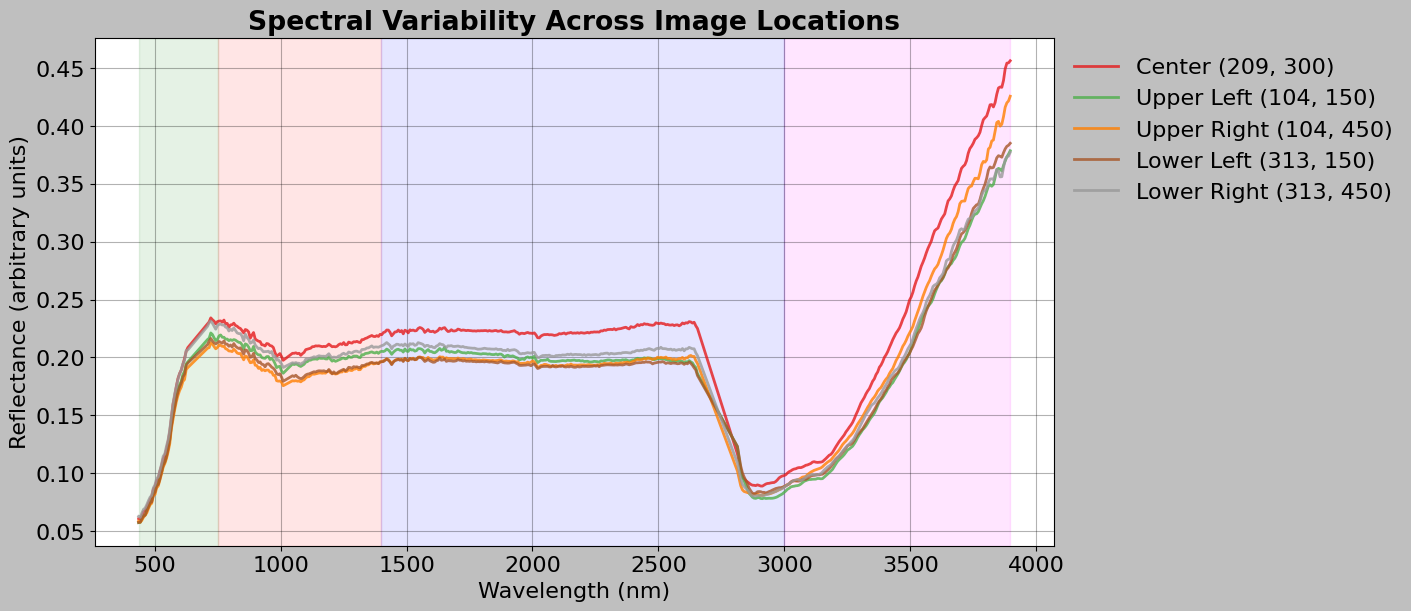

In [8]:
# Select several pixels from different parts of the image
sample_pixels = [
    (center_row, center_col, "Center"),
    (img_data.height // 4, img_data.width // 4, "Upper Left"),
    (img_data.height // 4, 3 * img_data.width // 4, "Upper Right"),
    (3 * img_data.height // 4, img_data.width // 4, "Lower Left"),
    (3 * img_data.height // 4, 3 * img_data.width // 4, "Lower Right"),
]

# Create plot
fig, ax = plt.subplots(figsize=(14, 6), layout="constrained")

colors = plt.cm.Set1(np.linspace(0, 1, len(sample_pixels)))

for (row, col, label), color in zip(sample_pixels, colors):
    spectrum = img_data.hsi[row, col, :]
    ax.plot(
        img_data.wavelength,
        spectrum,
        label=f"{label} ({row}, {col})",
        linewidth=2,
        alpha=0.8,
        color=color,
    )

# Add spectral region backgrounds
ax.axvspan(wl.min(), 750, alpha=0.1, color="green")
ax.axvspan(750, 1400, alpha=0.1, color="red")
ax.axvspan(1400, 3000, alpha=0.1, color="blue")
ax.axvspan(3000, wl.max(), alpha=0.1, color="magenta")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance (arbitrary units)")
ax.set_title(
    "Spectral Variability Across Image Locations",
    fontweight="bold",
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.grid(True, alpha=0.3)
plt.show()

### 4.3 Using the HSIMars Plotting Methods

The `HSIMars` class provides convenient methods for plotting.

Generating spectrum plot with convex hull removal...
(This enhances absorption features by removing the overall spectral shape)


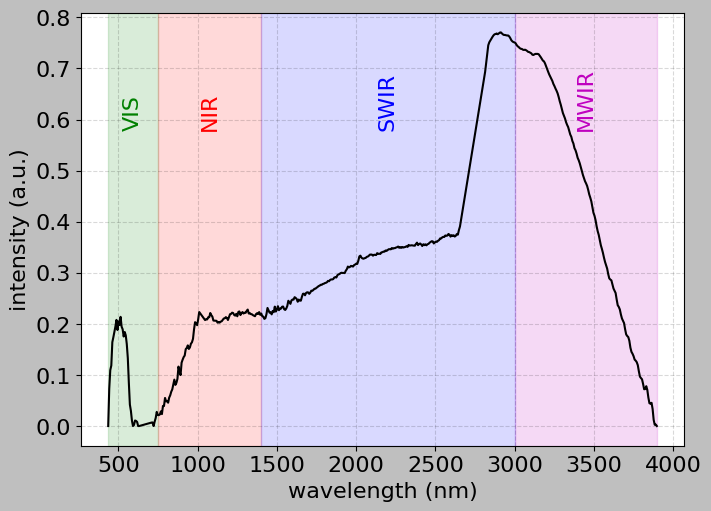

In [9]:
# Plot a single pixel spectrum with convex hull removal
# Convex hull removal normalizes the continuum to emphasize absorption features
print("Generating spectrum plot with convex hull removal...")
print(
    "(This enhances absorption features by removing the overall spectral shape)"
)

hsi.plot_spectra(
    px=[center_row, center_col],
    convex_hull=True,  # Apply continuum removal
    bands=True,  # Show spectral region labels
)

Plotting average spectrum of 121 pixels (11x11 region)
The shaded area shows ±1 standard deviation


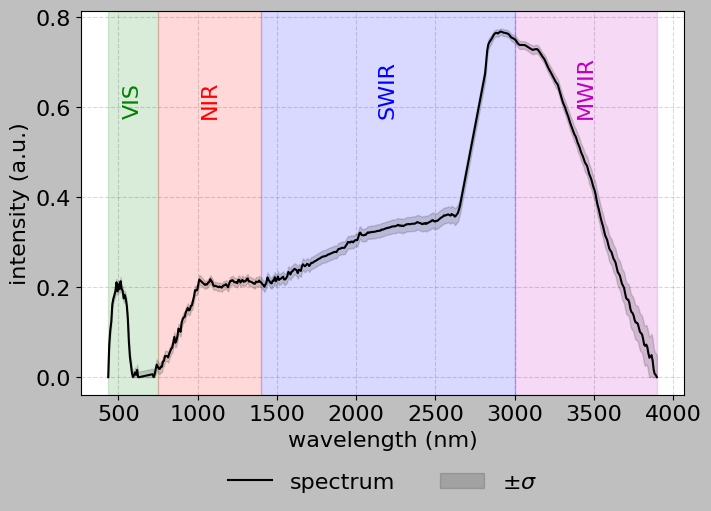

In [10]:
# Plot average spectrum of a region with standard deviation
# This shows spectral variability within a local area
region_pixels = [
    [center_row + dr, center_col + dc]
    for dr in range(-5, 6)
    for dc in range(-5, 6)
]

print(
    f"Plotting average spectrum of {len(region_pixels)} pixels (11x11 region)"
)
print("The shaded area shows ±1 standard deviation")

hsi.plot_spectra(
    px=region_pixels,
    convex_hull=True,
    bands=True,
)

## 5. Ground Truth Annotations

For supervised machine learning, we need **labelled data**. We thus explore the ground truth annotations.

In [11]:
# Load the annotation data
ann_data = hsi.get_annotations()

print("=" * 50)
print("ANNOTATION DATA PROPERTIES")
print("=" * 50)
print(f"📐 Annotation shape: {ann_data.shape}")
print(f"   - Height: {ann_data.height} pixels")
print(f"   - Width: {ann_data.width} pixels")
print(f"📊 Data type: {ann_data.dtype}")
print(f"\n🏷️  Unique labels: {np.unique(ann_data.labels)}")
print(f"   Number of classes: {len(np.unique(ann_data.labels))}")
print("=" * 50)

ANNOTATION DATA PROPERTIES
📐 Annotation shape: (418, 600)
   - Height: 418 pixels
   - Width: 600 pixels
📊 Data type: uint8

🏷️  Unique labels: [0 1 2 3 4 5 6]
   Number of classes: 7


### 5.1 Understanding the Label Distribution

Consider how many pixels belong to each class and calculate class statistics.


CLASS DISTRIBUTION
Class 0 (background):  230710 pixels (91.99%)
Class 1:                  940 pixels ( 0.37%)
Class 2:                 1472 pixels ( 0.59%)
Class 3:                 1560 pixels ( 0.62%)
Class 4:                 6963 pixels ( 2.78%)
Class 5:                 8697 pixels ( 3.47%)
Class 6:                  458 pixels ( 0.18%)


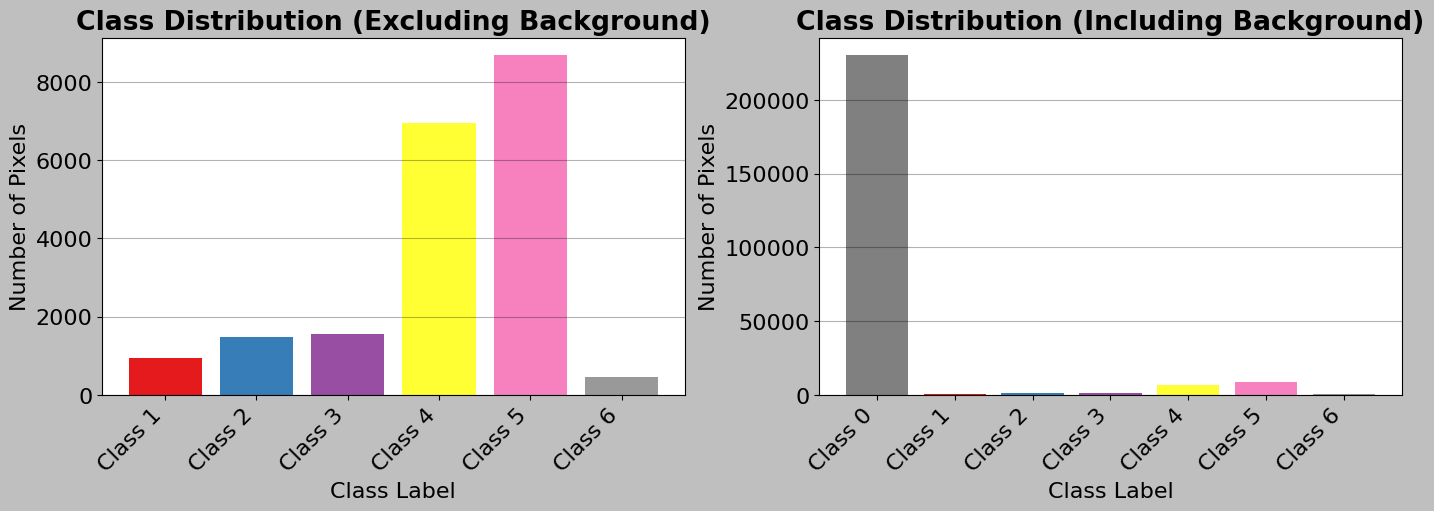

In [12]:
# Calculate class statistics
unique_labels = np.unique(ann_data.labels)
label_counts = {
    label: np.sum(ann_data.labels == label) for label in unique_labels
}

print("\nCLASS DISTRIBUTION")
print("=" * 50)
total_pixels = ann_data.height * ann_data.width

for label in sorted(unique_labels):
    count = label_counts[label]
    percentage = 100 * count / total_pixels

    if label == 0:
        print(
            f"Class {label} (background): {count:7d} pixels ({percentage:5.2f}%)"
        )
    else:
        print(
            f"Class {label}:              {count:7d} pixels ({percentage:5.2f}%)"
        )

print("=" * 50)

# Create a pie chart for better visualization
labeled_pixels = total_pixels - label_counts[0]
class_percentages = [
    (label_counts[lab] / labeled_pixels * 100)
    for lab in unique_labels
    if lab != 0
]
class_labels_text = [f"Class {lab}" for lab in unique_labels if lab != 0]
class_labels_text_bg = [f"Class {lab}" for lab in unique_labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), layout="constrained")

# Bar chart excluding background
colors = plt.cm.Set1(np.linspace(0, 1, len(class_labels_text)))
ax1.bar(
    range(len(class_labels_text)),
    [label_counts[lab] for lab in unique_labels if lab != 0],
    color=colors,
)
ax1.set_xlabel("Class Label")
ax1.set_ylabel("Number of Pixels")
ax1.set_title("Class Distribution (Excluding Background)", fontweight="bold")
ax1.set_xticks(range(len(class_labels_text)))
ax1.set_xticklabels(class_labels_text, rotation=45, ha="right")
ax1.grid(True, alpha=0.3, axis="y")

# Bar chart including background
ax2.bar(
    range(len(unique_labels)),
    [label_counts[lab] for lab in sorted(unique_labels)],
    color=["gray"] + list(colors),
)
ax2.set_xlabel("Class Label")
ax2.set_ylabel("Number of Pixels")
ax2.set_title("Class Distribution (Including Background)", fontweight="bold")
ax2.set_xticks(range(len(unique_labels)))
ax2.set_xticklabels(class_labels_text_bg, rotation=45, ha="right")
ax2.grid(True, alpha=0.3, axis="y")

plt.show()

### 5.2 Visualizing Annotations Spatially

Let us visualize where each class is located in the image.

In [13]:
np.arange(1, len(unique_labels) - 1, 5 / 6)

array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
       5.16666667])

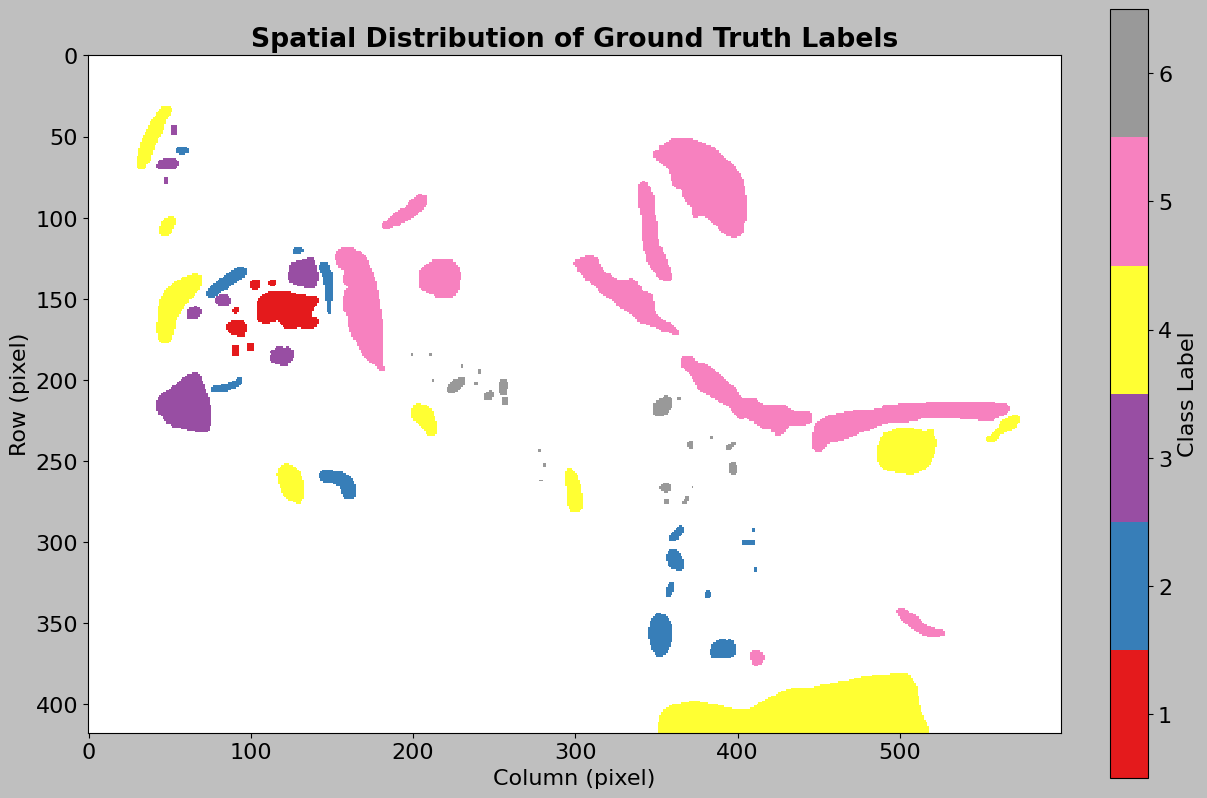

In [14]:
# Create a color-mapped visualization of annotations
fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")

# Create a masked array to hide background
masked_labels = np.ma.masked_where(ann_data.labels == 0, ann_data.labels)

# Display with colormap
cmap = mpl.colors.ListedColormap(
    plt.cm.Set1(np.linspace(0, 1, len(unique_labels) - 1))
)
im = ax.imshow(masked_labels, cmap=cmap, interpolation="nearest")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
dx = (len(unique_labels) - 2) / (len(unique_labels) - 1)
ticks = np.arange(1, len(unique_labels) - 1, dx)
cbar.set_ticks(ticks + dx / 2.0)
cbar.set_ticklabels(unique_labels[unique_labels != 0])
cbar.set_label("Class Label")

ax.set_title(
    "Spatial Distribution of Ground Truth Labels",
    fontweight="bold",
)
ax.set_xlabel("Column (pixel)")
ax.set_ylabel("Row (pixel)")

plt.show()

### 5.3 Using HSIMars Display Methods

The `HSIMars` class provides convenient visualization methods. Let's use them to see the overlay.

In [15]:
# This will open an OpenCV window showing three panels:
# - Left: False-color HSI
# - Middle: Annotations
# - Right: Overlay
print("Note: The display() method opens an OpenCV window.")
print("Press any key on the keyboard to close it.")
print("\nDisplaying image with annotations overlay...")

hsi.display()

print("✅ Display complete!")

Note: The display() method opens an OpenCV window.
Press any key on the keyboard to close it.

Displaying image with annotations overlay...
✅ Display complete!


## 6. Statistical Analysis

Consider now an exploratory data analysis to understand the data distribution and quality.

### 6.1 Overall Image Statistics

First, consider global statistics across the entire hyperspectral cube.

GLOBAL IMAGE STATISTICS
Minimum value: 0.0496
Maximum value: 0.5765
Mean value: 0.1934
Standard deviation: 0.0651
Median value: 0.1972


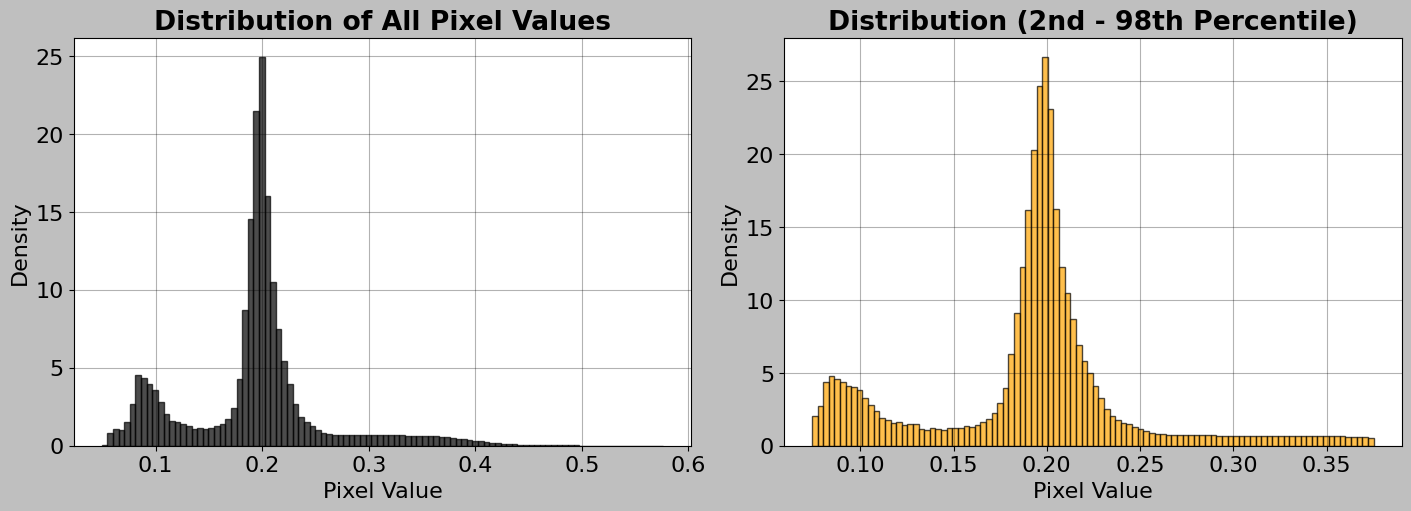

In [16]:
# Calculate statistics for the entire image
print("=" * 50)
print("GLOBAL IMAGE STATISTICS")
print("=" * 50)
print(f"Minimum value: {img_data.hsi.min():.4f}")
print(f"Maximum value: {img_data.hsi.max():.4f}")
print(f"Mean value: {img_data.hsi.mean():.4f}")
print(f"Standard deviation: {img_data.hsi.std():.4f}")
print(f"Median value: {np.median(img_data.hsi):.4f}")
print("=" * 50)

# Distribution of pixel values
fig, ax = plt.subplots(1, 2, figsize=(14, 5), layout="constrained")

# Histogram of all pixel values
ax1 = ax[0]
ax1.hist(
    img_data.hsi.ravel(), bins=100, density=True, edgecolor="black", alpha=0.7
)
ax1.set_xlabel("Pixel Value")
ax1.set_ylabel("Density")
ax1.set_title("Distribution of All Pixel Values", fontweight="bold")
ax1.grid(True, alpha=0.3)

# Histogram with percentile clipping for better visualization
ax2 = ax[1]
p2, p98 = np.percentile(img_data.hsi.ravel(), [2, 98])
clipped_data = img_data.hsi.ravel()
clipped_data = clipped_data[(clipped_data >= p2) & (clipped_data <= p98)]
ax2.hist(
    clipped_data,
    bins=100,
    density=True,
    edgecolor="black",
    alpha=0.7,
    color="orange",
)
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Density")
ax2.set_title("Distribution (2nd - 98th Percentile)", fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.show()

### 6.2 Band-wise Statistics

Different spectral bands can have very different characteristics.

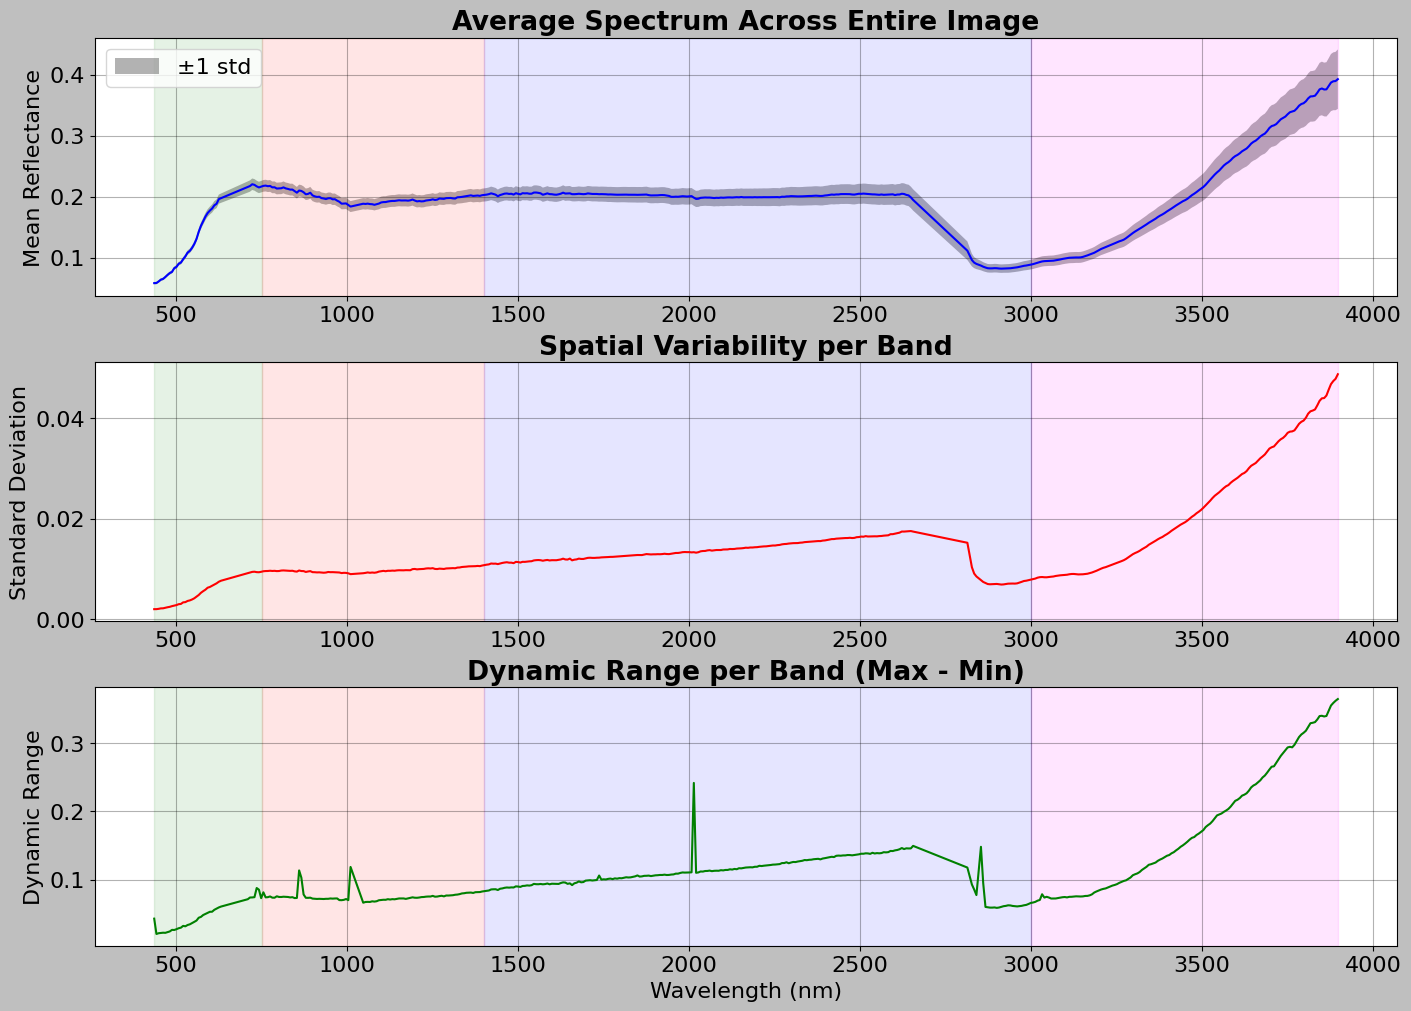

In [17]:
# Calculate mean and std for each band
band_means = img_data.hsi.mean(axis=(0, 1))  # Average over spatial dimensions
band_stds = img_data.hsi.std(axis=(0, 1))
band_mins = img_data.hsi.min(axis=(0, 1))
band_maxs = img_data.hsi.max(axis=(0, 1))

# Create comprehensive band statistics plot
fig, ax = plt.subplots(3, 1, figsize=(14, 10), layout="constrained")

# Mean reflectance per band
ax1 = ax[0]
ax1.plot(img_data.wavelength, band_means, "b-", linewidth=1.5)
ax1.fill_between(
    img_data.wavelength,
    band_means - band_stds,
    band_means + band_stds,
    alpha=0.3,
    label="±1 std",
)
ax1.axvspan(wl.min(), 750, alpha=0.1, color="green")
ax1.axvspan(750, 1400, alpha=0.1, color="red")
ax1.axvspan(1400, 3000, alpha=0.1, color="blue")
ax1.axvspan(3000, wl.max(), alpha=0.1, color="magenta")
ax1.set_ylabel("Mean Reflectance")
ax1.set_title("Average Spectrum Across Entire Image", fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Standard deviation per band
ax2 = ax[1]
ax2.plot(img_data.wavelength, band_stds, "r-", linewidth=1.5)
ax2.axvspan(wl.min(), 750, alpha=0.1, color="green")
ax2.axvspan(750, 1400, alpha=0.1, color="red")
ax2.axvspan(1400, 3000, alpha=0.1, color="blue")
ax2.axvspan(3000, wl.max(), alpha=0.1, color="magenta")
ax2.set_ylabel("Standard Deviation")
ax2.set_title("Spatial Variability per Band", fontweight="bold")
ax2.grid(True, alpha=0.3)

# Dynamic range per band
ax3 = ax[2]
ax3.plot(img_data.wavelength, band_maxs - band_mins, "g-", linewidth=1.5)
ax3.axvspan(wl.min(), 750, alpha=0.1, color="green")
ax3.axvspan(750, 1400, alpha=0.1, color="red")
ax3.axvspan(1400, 3000, alpha=0.1, color="blue")
ax3.axvspan(3000, wl.max(), alpha=0.1, color="magenta")
ax3.set_xlabel("Wavelength (nm)")
ax3.set_ylabel("Dynamic Range")
ax3.set_title("Dynamic Range per Band (Max - Min)", fontweight="bold")
ax3.grid(True, alpha=0.3)

plt.show()

### 6.3 Histogram for Specific Bands

We can also use the HSIMars method to examine the distribution in specific bands of interest.

Plotting histogram for band near 2300.0 nm...
This wavelength is important for detecting carbonates!


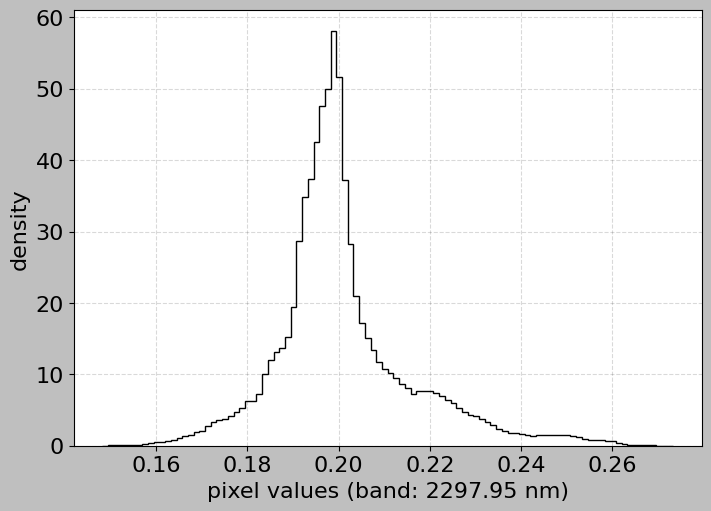

In [18]:
# Plot histogram for a band in the SWIR region (important for minerals)
swir_wavelength = 2300.0  # Around carbonate absorption
print(f"Plotting histogram for band near {swir_wavelength} nm...")
print("This wavelength is important for detecting carbonates!")

hsi.plot_histogram(band=swir_wavelength)

## 7. Class-Specific Spectral Analysis

Now let us connect the spectral data with the ground truth labels. This is crucial for understanding what makes each class distinguishable.

In [19]:
# Extract mean spectra for each labeled class
print("Calculating mean spectra for each class...")

class_spectra = {}
class_std = {}

for label in unique_labels:
    if label == 0:  # Skip background
        continue

    # Get all pixels belonging to this class
    mask = ann_data.labels == label
    pixels = img_data.hsi[mask]

    # Calculate mean and std
    class_spectra[label] = pixels.mean(axis=0)
    class_std[label] = pixels.std(axis=0)

    print(f"  Class {label}: {np.sum(mask)} pixels")

print("\n✅ Class spectra calculated!")

Calculating mean spectra for each class...
  Class 1: 940 pixels
  Class 2: 1472 pixels
  Class 3: 1560 pixels
  Class 4: 6963 pixels
  Class 5: 8697 pixels
  Class 6: 458 pixels

✅ Class spectra calculated!


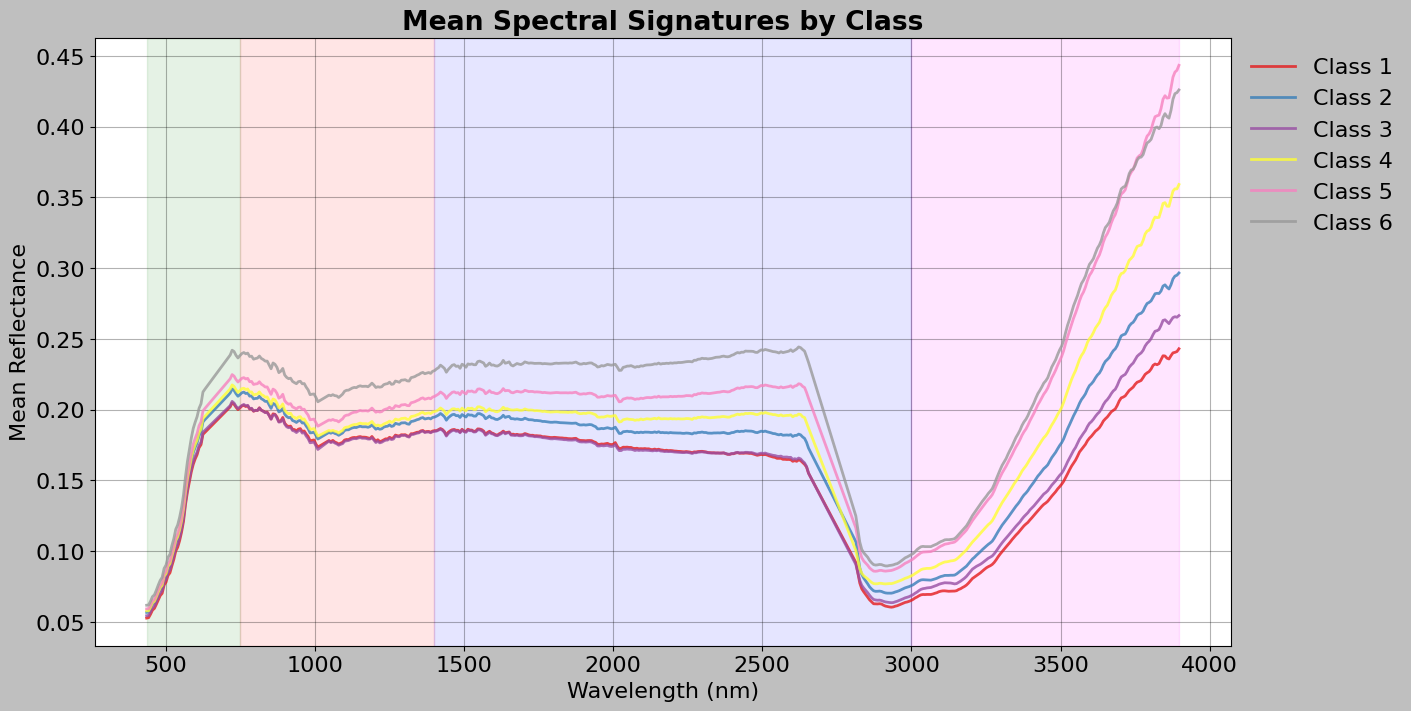

In [20]:
# Plot mean spectra for all classes
fig, ax = plt.subplots(figsize=(14, 7), layout="constrained")

colors = plt.cm.Set1(np.linspace(0, 1, len(class_spectra)))

for (label, spectrum), color in zip(class_spectra.items(), colors):
    ax.plot(
        img_data.wavelength,
        spectrum,
        label=f"Class {label}",
        linewidth=2,
        alpha=0.8,
        color=color,
    )

# Add spectral region backgrounds
ax.axvspan(wl.min(), 750, alpha=0.1, color="green")
ax.axvspan(750, 1400, alpha=0.1, color="red")
ax.axvspan(1400, 3000, alpha=0.1, color="blue")
ax.axvspan(3000, wl.max(), alpha=0.1, color="magenta")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Mean Reflectance")
ax.set_title("Mean Spectral Signatures by Class", fontweight="bold")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.grid(True, alpha=0.3)

plt.show()

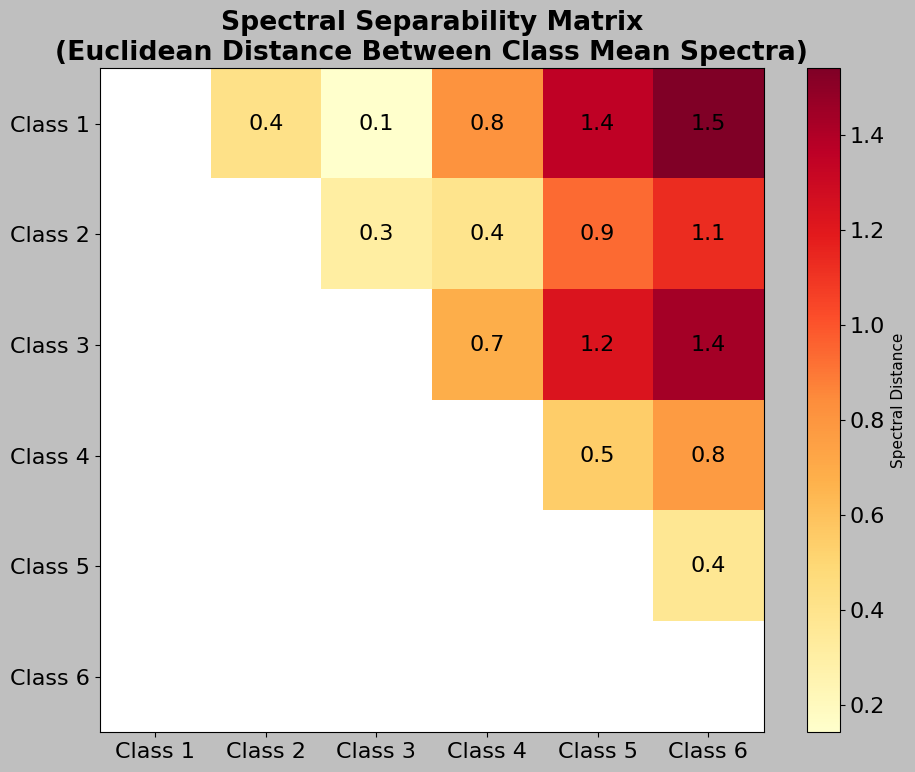

In [21]:
# Calculate spectral separability between classes
from scipy.spatial.distance import pdist, squareform

# Create matrix of mean spectra
labels_list = sorted([lab for lab in class_spectra.keys()])
spectra_matrix = np.array([class_spectra[lab] for lab in labels_list])

# Calculate pairwise distances
distances = squareform(pdist(spectra_matrix, metric="euclidean"))
mask = np.tri(distances.shape[0])
distances = np.ma.array(distances, mask=mask)

# Visualize as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(distances, cmap="YlOrRd", interpolation="nearest")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Spectral Distance", fontsize=11)

# Set ticks and labels
ax.set_xticks(range(len(labels_list)))
ax.set_yticks(range(len(labels_list)))
ax.set_xticklabels([f"Class {lab}" for lab in labels_list])
ax.set_yticklabels([f"Class {lab}" for lab in labels_list])

# Add text annotations
for i in range(len(labels_list)):
    for j in range(i + 1, len(labels_list)):
        text = ax.text(
            j,
            i,
            f"{distances[i, j]:.1f}",
            ha="center",
            va="center",
            color="black",
        )

ax.set_title(
    "Spectral Separability Matrix\n(Euclidean Distance Between Class Mean Spectra)",
    fontweight="bold",
)

plt.tight_layout()
plt.show()

## 8. Feature Engineering Considerations

Before applying machine learning, we need to think about features. Since we work with spectra, we can use them as features directly (even though feature engineering might still be beneficial).

### 8.1 Correlation Between Bands

Adjacent spectral bands are often highly correlated (redundant information).

Calculating correlation matrix for 97 bands...
(Using subset for computational efficiency)


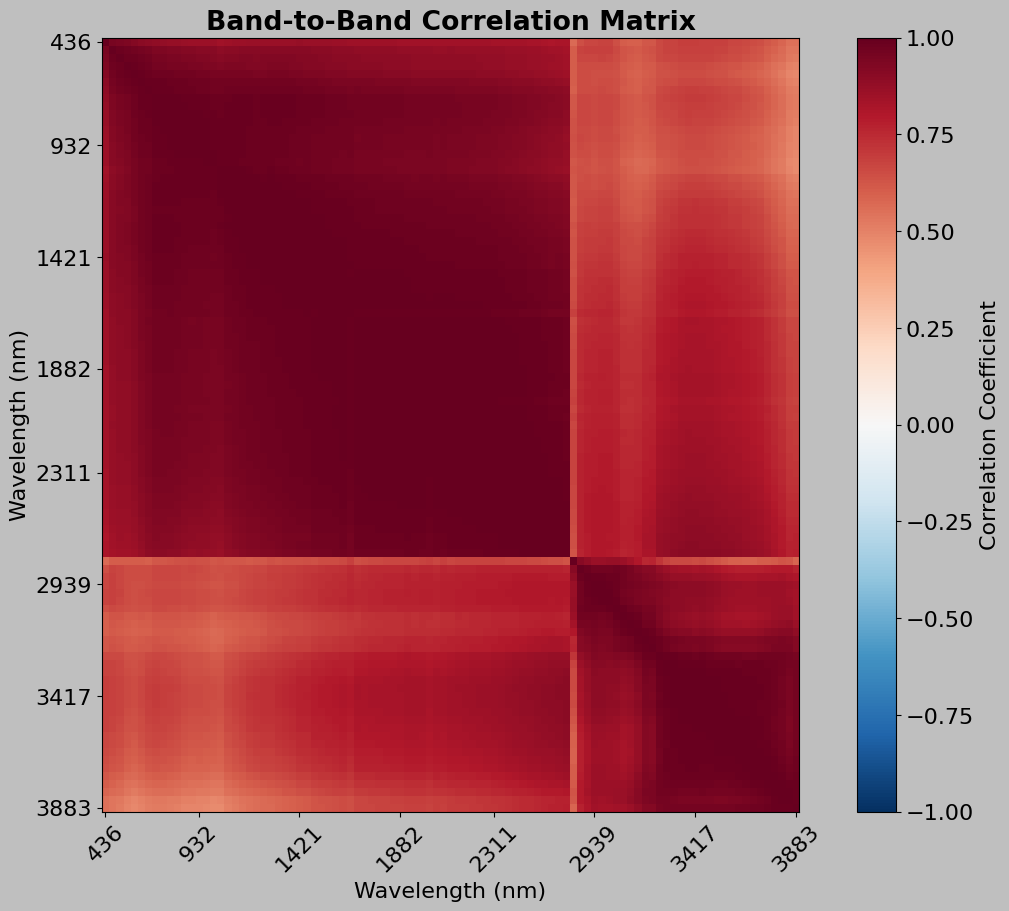

In [22]:
# Calculate correlation matrix (use a subset for computational efficiency)
# Sample every 5th band to make computation faster
sample_indices = np.arange(0, img_data.channels, 5)
sample_wavelengths = img_data.wavelength[sample_indices]

# Reshape for correlation calculation: (n_pixels, n_bands_subset)
n_pixels = img_data.height * img_data.width
hsi_reshaped = img_data.hsi.reshape(n_pixels, -1)
hsi_subset = hsi_reshaped[:, sample_indices]

# Calculate correlation matrix
print(f"Calculating correlation matrix for {len(sample_indices)} bands...")
print("(Using subset for computational efficiency)")
correlation_matrix = np.corrcoef(hsi_subset.T)

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 9), layout="constrained")
im = ax.imshow(
    correlation_matrix,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation Coefficient")

# Set tick labels (show wavelengths, not indices)
tick_positions = np.linspace(0, len(sample_indices) - 1, 8).astype(int)
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(
    [f"{sample_wavelengths[i]:.0f}" for i in tick_positions], rotation=45
)
ax.set_yticklabels([f"{sample_wavelengths[i]:.0f}" for i in tick_positions])

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Wavelength (nm)")
ax.set_title("Band-to-Band Correlation Matrix", fontweight="bold")

plt.show()

In [23]:
# Check for anomalies
print("=" * 70)
print("DATA QUALITY CHECKS")
print("=" * 70)

# Check for NaN or Inf values
n_nan = np.sum(np.isnan(img_data.hsi))
n_inf = np.sum(np.isinf(img_data.hsi))
print(f"✓ NaN values: {n_nan}")
print(f"✓ Inf values: {n_inf}")

# Check for negative values (unusual in reflectance data)
n_negative = np.sum(img_data.hsi < 0)
pct_negative = 100 * n_negative / img_data.hsi.size
print(f"✓ Negative values: {n_negative} ({pct_negative:.3f}%)")

# Check for zero values
n_zero = np.sum(img_data.hsi == 0)
pct_zero = 100 * n_zero / img_data.hsi.size
print(f"✓ Zero values: {n_zero} ({pct_zero:.3f}%)")

# Check dynamic range
print(f"\n✓ Value range: [{img_data.hsi.min():.4f}, {img_data.hsi.max():.4f}]")
print(f"✓ Mean ± std: {img_data.hsi.mean():.4f} ± {img_data.hsi.std():.4f}")

# Identify potential outlier pixels (very bright or very dark)
pixel_means = img_data.hsi.mean(axis=2)  # Average across bands for each pixel
mean_threshold_low = np.percentile(pixel_means, 1)
mean_threshold_high = np.percentile(pixel_means, 99)
n_outliers = np.sum(
    (pixel_means < mean_threshold_low) | (pixel_means > mean_threshold_high)
)
pct_outliers = 100 * n_outliers / (img_data.height * img_data.width)
print(
    f"\n✓ Potential outlier pixels (outside 1-99 percentile): {n_outliers} ({pct_outliers:.2f}%)"
)

print("=" * 70)

DATA QUALITY CHECKS
✓ NaN values: 0
✓ Inf values: 0
✓ Negative values: 0 (0.000%)
✓ Zero values: 0 (0.000%)

✓ Value range: [0.0496, 0.5765]
✓ Mean ± std: 0.1934 ± 0.0651

✓ Potential outlier pixels (outside 1-99 percentile): 5016 (2.00%)
